In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read a CSV file into a DataFrame
# change the path to the location of the data files
applicants_2nd = pd.read_csv('../raw_data/2ndBatch_Applicants.csv', encoding='latin1',)
entrance_scores_2nd = pd.read_csv('../raw_data/2ndBatch_Entrance_Scores.csv')
student_data_2nd = pd.read_csv('../raw_data/2ndBatch_Studentdata.csv')
original_2nd = pd.read_csv('../raw_data/GED_2nd Batch Data_Original.csv')

# Rename columns of original_2nd to match the applicants_2nd columns
original_2nd.columns = ['Unnamed', 'Student ID', 'Gender', 'Age', 'Location', 'Highest Education', 'Entranced',
                        'Specilization in High School', 'Current Job/School']

# Drop the 'Unnamed' column from original_2nd
original_2nd.drop(columns=['Unnamed'], inplace=True)

# Merge the datasets on 'Student ID', prioritizing columns from original_2nd
applicants_2nd = pd.merge(applicants_2nd, 
                        original_2nd[['Student ID', 'Gender', 'Specilization in High School', 'Current Job/School']], 
                        on='Student ID', how='left', suffixes=('_applicants', '_original'))

# Print the column names of the combined DataFrame to check for any discrepancies
print(applicants_2nd.columns)

# Assign the Gender column directly from original_2nd
applicants_2nd['Gender'] = applicants_2nd['Gender']

# Replace "Specilization in High School" and "Current Job/School" in applicants_2nd with those from original_2nd
applicants_2nd['Specilization in High School'] = applicants_2nd['Specilization in High School_original']
applicants_2nd['Current Job/School'] = applicants_2nd['Current Job/School_original']


# Drop the redundant columns
applicants_2nd.drop(columns=['Specilization in High School_applicants', 
                           'Specilization in High School_original', 'Current Job/School_applicants', 
                           'Current Job/School_original'], inplace=True)

applicants_2nd = applicants_2nd.drop_duplicates()
entrance_scores_2nd = entrance_scores_2nd.drop_duplicates()
student_data_2nd = student_data_2nd.drop_duplicates()

Index(['Student ID', 'Age', 'Location', 'Highest Education', 'Entranced',
       'Specilization in High School_applicants',
       'Current Job/School_applicants', 'Gender',
       'Specilization in High School_original', 'Current Job/School_original'],
      dtype='object')


In [2]:
print(applicants_2nd)

        Student ID            Age           Location Highest Education  \
0     GED202402_01             18  Thailand (Others)    Pass 9th Grade   
1     GED202402_02             17           Mandalay   Pass 10th Grade   
2     GED202402_03  22 years old              Yangon   Pass 10th Grade   
3     GED202402_04             19                Mon             Other   
4     GED202402_05             16             Yangon   Pass 10th Grade   
..             ...            ...                ...               ...   
100  GED202402_101             19              Kayin   Pass 10th Grade   
101  GED202402_102             18             Yangon    Pass 9th Grade   
102  GED202402_103             18               Bago             Other   
103  GED202402_104             17             Yangon    Pass 9th Grade   
104  GED202402_105       16 years                Mon    Pass 9th Grade   

    Entranced  Gender Specilization in High School  \
0         Yes     NaN                          NaN   
1  

In [3]:
# Clean column names by removing extra spaces
applicants_2nd.columns = applicants_2nd.columns.str.strip()
entrance_scores_2nd.columns = entrance_scores_2nd.columns.str.strip()
student_data_2nd.columns = student_data_2nd.columns.str.strip()

# Drop the last two rows
entrance_scores_2nd = entrance_scores_2nd.iloc[:-2]  # Keeps all rows except the last two

# Identify the problematic rows manually
print(applicants_2nd[['Age']].loc[[2, 30, 88, 104]])  # Check the specific rows

# # Manually correct the values
applicants_2nd.loc[2, 'Age'] = 22  # Convert '1/1/1998' to age
applicants_2nd.loc[30, 'Age'] = 19  # Convert '2000' to age
applicants_2nd.loc[88, 'Age'] = 2024-2001  # convert 15 yrs to 15
applicants_2nd.loc[104, 'Age'] = 16  # convert 15 yrs to 15

print(applicants_2nd[['Age']].loc[[2, 30, 88, 104]])  # Check the specific rows

print(entrance_scores_2nd)

               Age
2    22 years old 
30       19 years 
88      26.12.2001
104       16 years
    Age
2    22
30   19
88   23
104  16
        Student ID  English  Math  Interview  Final Score Pass/Fail
0     GED202402_01     38.0  45.0       70.0        50.05      Fail
1     GED202402_02      0.0   0.0        0.0         0.00      Fail
2     GED202402_03      0.0   0.0        0.0         0.00      Fail
3     GED202402_04      0.0   0.0        0.0         0.00      Fail
4     GED202402_05      0.0   0.0        0.0         0.00      Fail
..             ...      ...   ...        ...          ...       ...
100  GED202402_101     58.0  80.0       83.3        73.30      Pass
101  GED202402_102     84.0  90.0       73.3        82.90      Pass
102  GED202402_103     64.0  90.0       10.0        56.90      Fail
103  GED202402_104     64.0  90.0       86.7        79.90      Pass
104  GED202402_105      0.0   0.0        0.0         0.00      Fail

[105 rows x 6 columns]


In [4]:
# Join the three tables using 'Student ID' as the key
batch2_combined = pd.merge(applicants_2nd, entrance_scores_2nd, on='Student ID', how='inner')
batch2_combined = pd.merge(batch2_combined, student_data_2nd, on='Student ID', suffixes=('', '_studentdata'), how='inner')

# If both 'Name' columns exist, merge them into one 'Name' column
if 'Name' in batch2_combined.columns and 'Name_studentdata' in batch2_combined.columns:
    batch2_combined['Name'] = batch2_combined['Name'].combine_first(batch2_combined['Name_studentdata'])
    batch1_combined = batch2_combined.drop(columns=['Name_studentdata'])

# drop unnecessary columns
batch2_combined = batch2_combined.drop(columns=['Unnamed: 0'])

# Handle missing values
batch2_combined['Specilization in High School'] = batch2_combined['Specilization in High School'].fillna('Unknown')
batch2_combined['Current Job/School'] = batch2_combined['Current Job/School'].fillna('Unknown')

# Define a function to categorize commitment
def categorize_commitment(remarks):
    if remarks == 'Drop out' or remarks == 'Drop Out':
        return 'Low'  # 'Drop' indicates low commitment
    else:
        return 'High'  # All other remarks indicate high commitment

# Create a new 'Commitment' column
batch2_combined['Commitment'] = batch2_combined['Remarks'].apply(categorize_commitment)


# sort the data by 'Student ID'
# Extract the numeric part of 'Sr. Num' and convert it to integer for proper sorting
batch2_combined['Sr_Num_numeric'] = batch2_combined['Sr. Num'].astype(int)

# Sort by the numeric part
df_sorted = batch2_combined.sort_values(by='Sr_Num_numeric')

# Drop the helper column if it's no longer needed
df_sorted = df_sorted.drop(columns=['Sr_Num_numeric'])
batch2_combined = batch2_combined.drop(columns=['Sr_Num_numeric'])

# Rearrange the columns to place 'Gender' between 'Age' and 'Location'
columns = list(batch2_combined.columns)

# Get the positions of 'Age' and 'Location'
age_idx = columns.index('Age')
location_idx = columns.index('Location')

# Move the 'Gender' column to be after 'Age' and before 'Location'
# Remove 'Gender' from the original position and insert it at the correct index
columns.insert(location_idx, columns.pop(columns.index('Gender')))

# Reorder the DataFrame with the updated columns
batch2_combined = batch2_combined[columns]

# Define the Student IDs for each category
student_ids = ['GED202402_08', 'GED202402_14', 
               'GED202402_15','GED202402_18', 'GED202402_25', 'GED202402_27','GED202402_28', 'GED202402_38','GED202402_39','GED202402_59','GED202402_60',
               'GED202402_61','GED202402_64','GED202402_67','GED202402_68','GED202402_85','GED202402_90','GED202402_92','GED202402_93',
               'GED202402_101','GED202402_104', 'GED202402_105',]  # Example IDs with students; modify based on actual data
job_ids = ['GED202402_24','GED202402_91','GED202402_94']  # Example IDs with jobs; modify based on actual data

# Add a new column with default value as 'unknown'
batch2_combined['Socio-economic background'] = 'unknown'

# Set "student" for specific Student IDs
batch2_combined.loc[batch2_combined['Student ID'].isin(student_ids), 'Socio-economic background'] = 'student'

# Set "job" for specific Student IDs
batch2_combined.loc[batch2_combined['Student ID'].isin(job_ids), 'Socio-economic background'] = 'job'

In [5]:
# batch2_combined.to_csv('../combined_and_clean_data/2ndBatch_Combined.csv', index=False)

# 1. Get an overview of the demographic composition for Batch 2

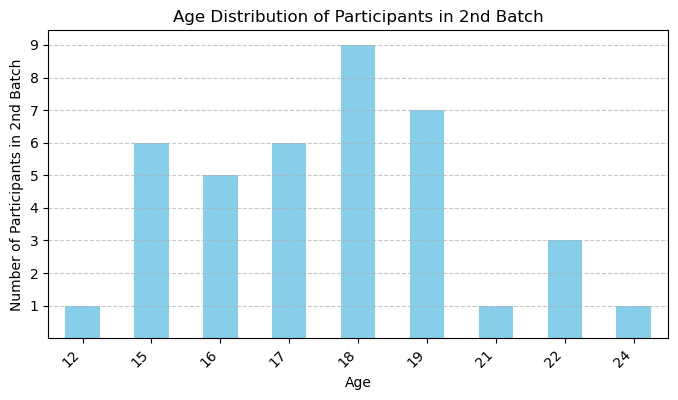

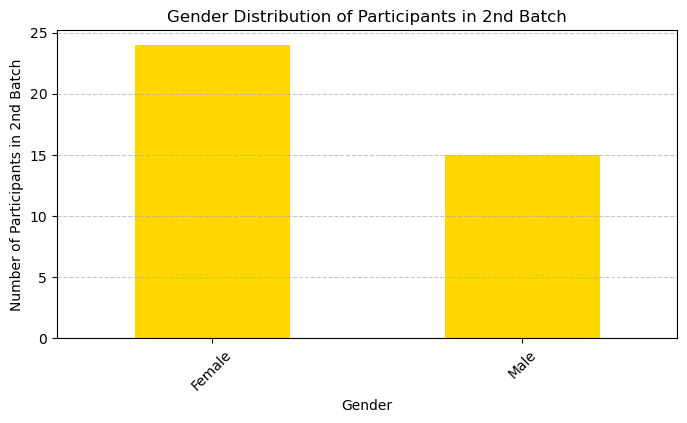

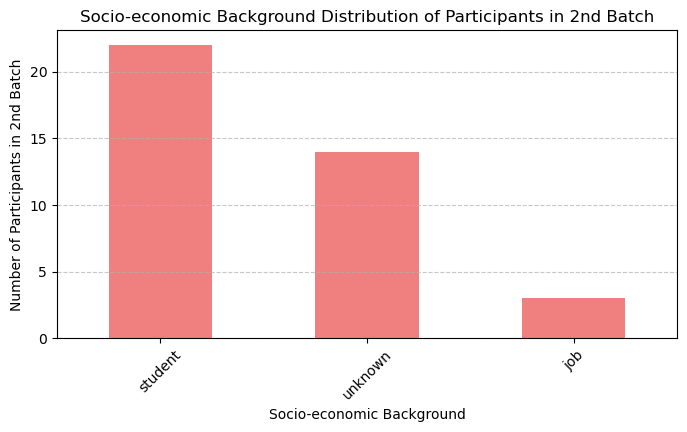

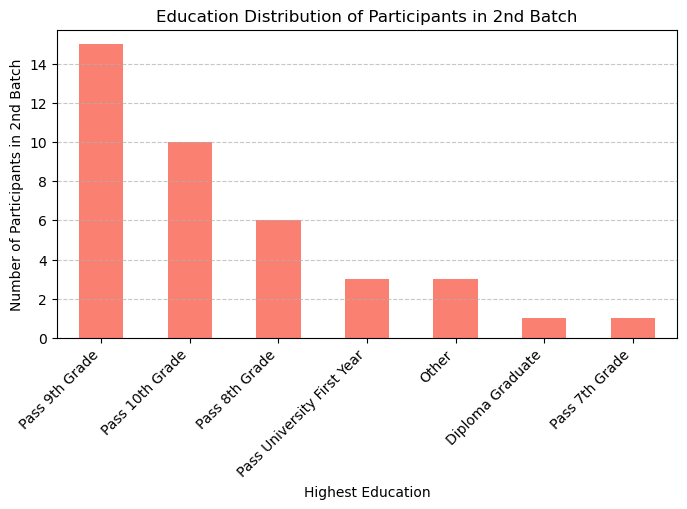

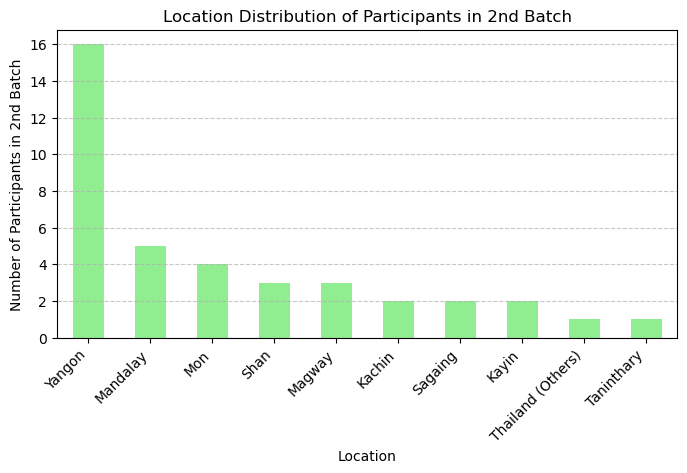

In [6]:
# 1. Plot Age Distribution
# Convert 'Age' column to numeric, forcing errors to NaN and filling with a default value (if needed)
batch2_combined['Age'] = pd.to_numeric(batch2_combined['Age'], errors='coerce').fillna(0).astype(int)

# 1. Plot Age Distribution
plt.figure(figsize=(8, 4))
batch2_combined['Age'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Age Distribution of Participants in 2nd Batch')
plt.xlabel('Age')
plt.ylabel('Number of Participants in 2nd Batch')
plt.yticks([1, 2, 3, 4,5,6,7,8,9])  # Show only whole numbers on the y-axis
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Plot Gender Distribution
plt.figure(figsize=(8, 4))
batch2_combined['Gender'].value_counts().plot(kind='bar', color='gold')
plt.title('Gender Distribution of Participants in 2nd Batch')
plt.xlabel('Gender')
plt.ylabel('Number of Participants in 2nd Batch')
plt.xticks(rotation=45, ha='center')  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Plot Socio-economic Background Distribution
plt.figure(figsize=(8, 4))
batch2_combined['Socio-economic background'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Socio-economic Background Distribution of Participants in 2nd Batch')
plt.xlabel('Socio-economic Background')
plt.ylabel('Number of Participants in 2nd Batch')
plt.xticks(rotation=45, ha='center')  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Plot Education Distribution
plt.figure(figsize=(8, 4))
batch2_combined['Highest Education'].value_counts().plot(kind='bar', color='salmon')
plt.title('Education Distribution of Participants in 2nd Batch')
plt.xlabel('Highest Education')
plt.ylabel('Number of Participants in 2nd Batch')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 5. Plot Location Distribution
plt.figure(figsize=(8, 4))
batch2_combined['Location'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Location Distribution of Participants in 2nd Batch')
plt.xlabel('Location')
plt.ylabel('Number of Participants in 2nd Batch')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Commitment and engagement for batch 2

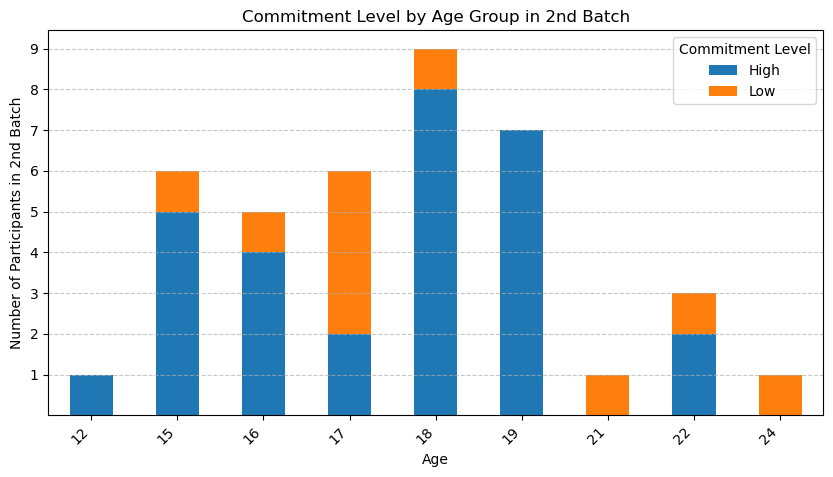

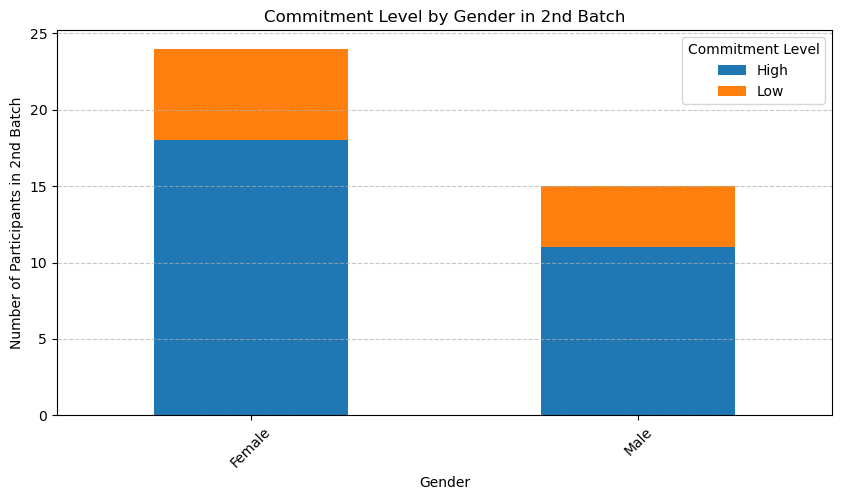

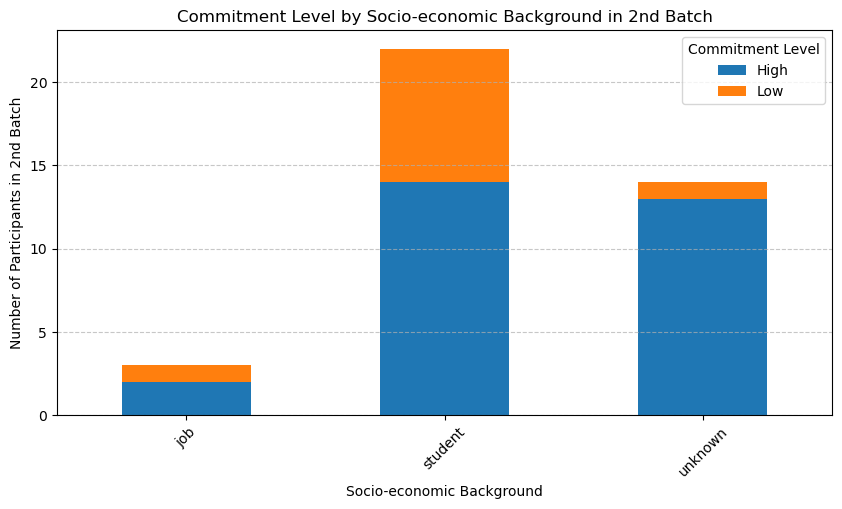

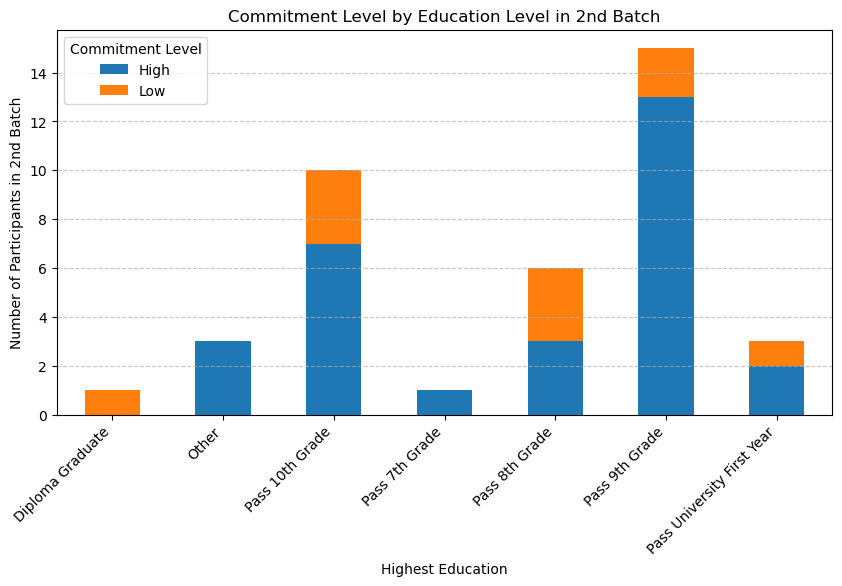

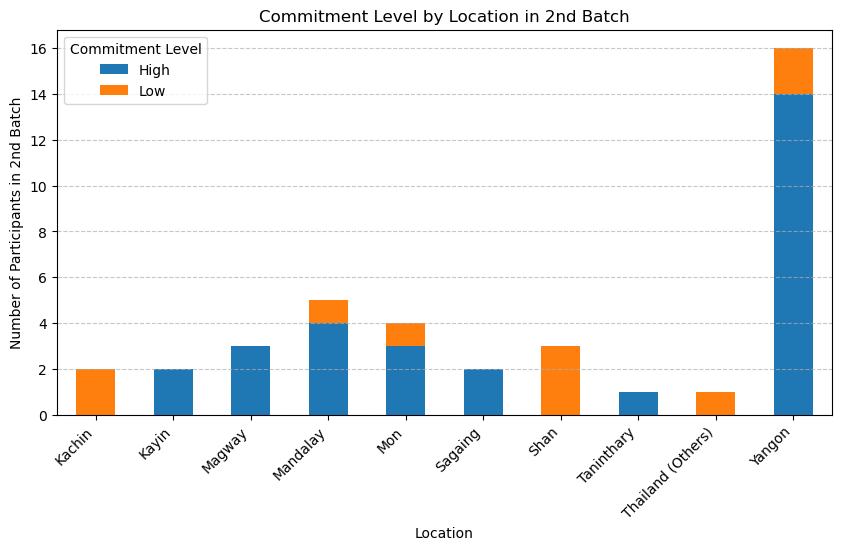

In [7]:
# 1. Analyze Commitment by Age Group
commitment_by_age = batch2_combined.groupby('Age')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_age.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Age Group in 2nd Batch')
plt.xlabel('Age')
plt.ylabel('Number of Participants in 2nd Batch')
plt.yticks([1, 2, 3, 4,5,6,7,8,9])  # Show only whole numbers on the y-axis
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()

# 2. Analyze Commitment by Gender
commitment_by_gender = batch2_combined.groupby('Gender')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_gender.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Gender in 2nd Batch')
plt.xlabel('Gender')
plt.ylabel('Number of Participants in 2nd Batch')
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()

# 3. Analyze Commitment by Socio-economic Background
commitment_by_socio = batch2_combined.groupby('Socio-economic background')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_socio.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Socio-economic Background in 2nd Batch')
plt.xlabel('Socio-economic Background')
plt.ylabel('Number of Participants in 2nd Batch')
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()

# 4. Analyze Commitment by Highest Education Level
commitment_by_education = batch2_combined.groupby('Highest Education')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_education.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Education Level in 2nd Batch')
plt.xlabel('Highest Education')
plt.ylabel('Number of Participants in 2nd Batch')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()

# 5. Analyze Commitment by Location
commitment_by_location = batch2_combined.groupby('Location')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_location.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Location in 2nd Batch')
plt.xlabel('Location')
plt.ylabel('Number of Participants in 2nd Batch')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()